In [4]:
import cv2
import numpy as np
import glob
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt


In [5]:
# Load genuine signature paths
gen_sign = (
    glob.glob(r"C:\Users\udayu\OneDrive\Desktop\infosys\Dataset-20241008T071237Z-001\Dataset\dataset1\real\*.*") +
    glob.glob(r"C:\Users\udayu\OneDrive\Desktop\infosys\Dataset-20241008T071237Z-001\Dataset\dataset2\real\*.*") +
    glob.glob(r"C:\Users\udayu\OneDrive\Desktop\infosys\Dataset-20241008T071237Z-001\Dataset\dataset3\real\*.*") +
    glob.glob(r"C:\Users\udayu\OneDrive\Desktop\infosys\Dataset-20241008T071237Z-001\Dataset\dataset4\real\*.*")
)

# Load forged signature paths
forg_sign = (
    glob.glob(r"C:\Users\udayu\OneDrive\Desktop\infosys\Dataset-20241008T071237Z-001\Dataset\dataset1\forge\*.*") +
    glob.glob(r"C:\Users\udayu\OneDrive\Desktop\infosys\Dataset-20241008T071237Z-001\Dataset\dataset2\forge\*.*") +
    glob.glob(r"C:\Users\udayu\OneDrive\Desktop\infosys\Dataset-20241008T071237Z-001\Dataset\dataset3\forge\*.*") +
    glob.glob(r"C:\Users\udayu\OneDrive\Desktop\infosys\Dataset-20241008T071237Z-001\Dataset\dataset4\forge\*.*")
)


In [6]:
# Split the data into train and test (80% train, 20% test)
train_ratio = 0.8
train_gen_sign = gen_sign[:int(len(gen_sign) * train_ratio)]
test_gen_sign = gen_sign[int(len(gen_sign) * train_ratio):]
train_forg_sign = forg_sign[:int(len(forg_sign) * train_ratio)]
test_forg_sign = forg_sign[int(len(forg_sign) * train_ratio):]

train_image_paths = train_gen_sign + train_forg_sign
test_image_paths = test_gen_sign + test_forg_sign


In [7]:
# Preprocessing functions
def preprocess_image(image_path, img_size=(256, 256), patch_size=(256, 256)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    img = cv2.resize(img, img_size)  # Resize to fixed size
    return img_to_patches(img, patch_size)

def img_to_patches(img, patch_size=(256, 256)):
    patches = []
    for i in range(0, img.shape[0], patch_size[0]):
        for j in range(0, img.shape[1], patch_size[1]):
            patch = img[i:i+patch_size[0], j:j+patch_size[1]].flatten()  # Flatten each patch
            patches.append(patch)
    return np.array(patches)


In [8]:
# Process images and store them as sequences of patches for both train and test
def process_images(image_paths, label):
    X_data = []
    y_data = []
    for image_path in image_paths:
        try:
            patches = preprocess_image(image_path)
            X_data.append(patches)
            y_data.append(label)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    return np.array(X_data), np.array(y_data)


In [9]:
# Create training dataset
X_train_real, y_train_real = process_images(train_gen_sign, label=0)  # 0 for real
X_train_forg, y_train_forg = process_images(train_forg_sign, label=1)  # 1 for forged

# Create test dataset
X_test_real, y_test_real = process_images(test_gen_sign, label=0)  # 0 for real
X_test_forg, y_test_forg = process_images(test_forg_sign, label=1)  # 1 for forged

# Combine real and forged data
X_train = np.concatenate([X_train_real, X_train_forg], axis=0)
y_train = np.concatenate([y_train_real, y_train_forg], axis=0)
X_test = np.concatenate([X_test_real, X_test_forg], axis=0)
y_test = np.concatenate([y_test_real, y_test_forg], axis=0)


In [10]:
# Shuffle the training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Shuffle the test data
test_indices = np.random.permutation(len(X_test))
X_test = X_test[test_indices]
y_test = y_test[test_indices]

# Print shapes for debugging
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (576, 1, 65536)
y_train shape: (576,)
X_test shape: (144, 1, 65536)
y_test shape: (144,)


In [11]:
# Reshape for LSTM input (batch_size, time_steps, input_dim)
timesteps = X_train.shape[1]  # number of patches per image
features = X_train.shape[2]    # number of features per patch

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [12]:
# Create the model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(timesteps, features)),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 2 classes: genuine and forged
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


C:\Users\udayu\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 128)                 │      33,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,596,098 (128.16 MB)

 Trainable params: 33,596,098 (128.16 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Save the model in the recommended Keras format
model.save('bi_rnn_signature_verification_model.keras')


In [17]:
# Your model training code here...

# Save the model
model.save('bi_rnn_signature_verification_model.keras')


In [18]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.4521 - loss: 0.7009 - val_accuracy: 0.4861 - val_loss: 0.6960
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.4884 - loss: 0.6967 - val_accuracy: 0.5000 - val_loss: 0.6963
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.5128 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6955
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.5052 - loss: 0.6954 - val_accuracy: 0.5000 - val_loss: 0.6972
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.5181 - loss: 0.6941 - val_accuracy: 0.4861 - val_loss: 0.6955
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.4591 - loss: 0.6964 - val_accuracy: 0.5000 - val_loss: 0.6950
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.5236 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6972
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.5025 - loss: 0.6960 - val_accuracy: 0

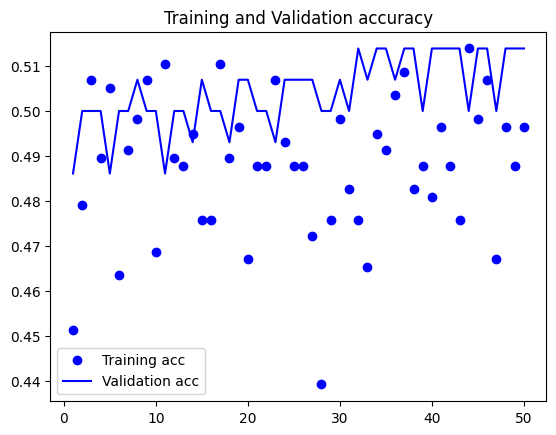

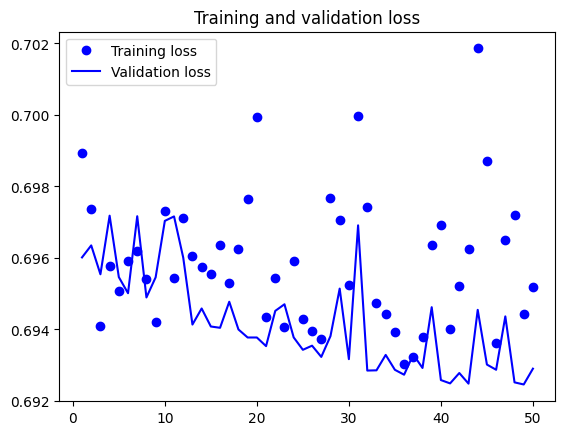

In [20]:
# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [21]:
# Get the final loss and accuracy
final_loss, final_accuracy = model.evaluate(X_test, y_test)

# Print the results in percentage form
print('Final loss: {:.2f}%'.format(final_loss * 100))
print('Final Accuracy: {:.2f}%'.format(final_accuracy * 100))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5055 - loss: 0.6948
Final loss: 69.29%
Final Accuracy: 51.39%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


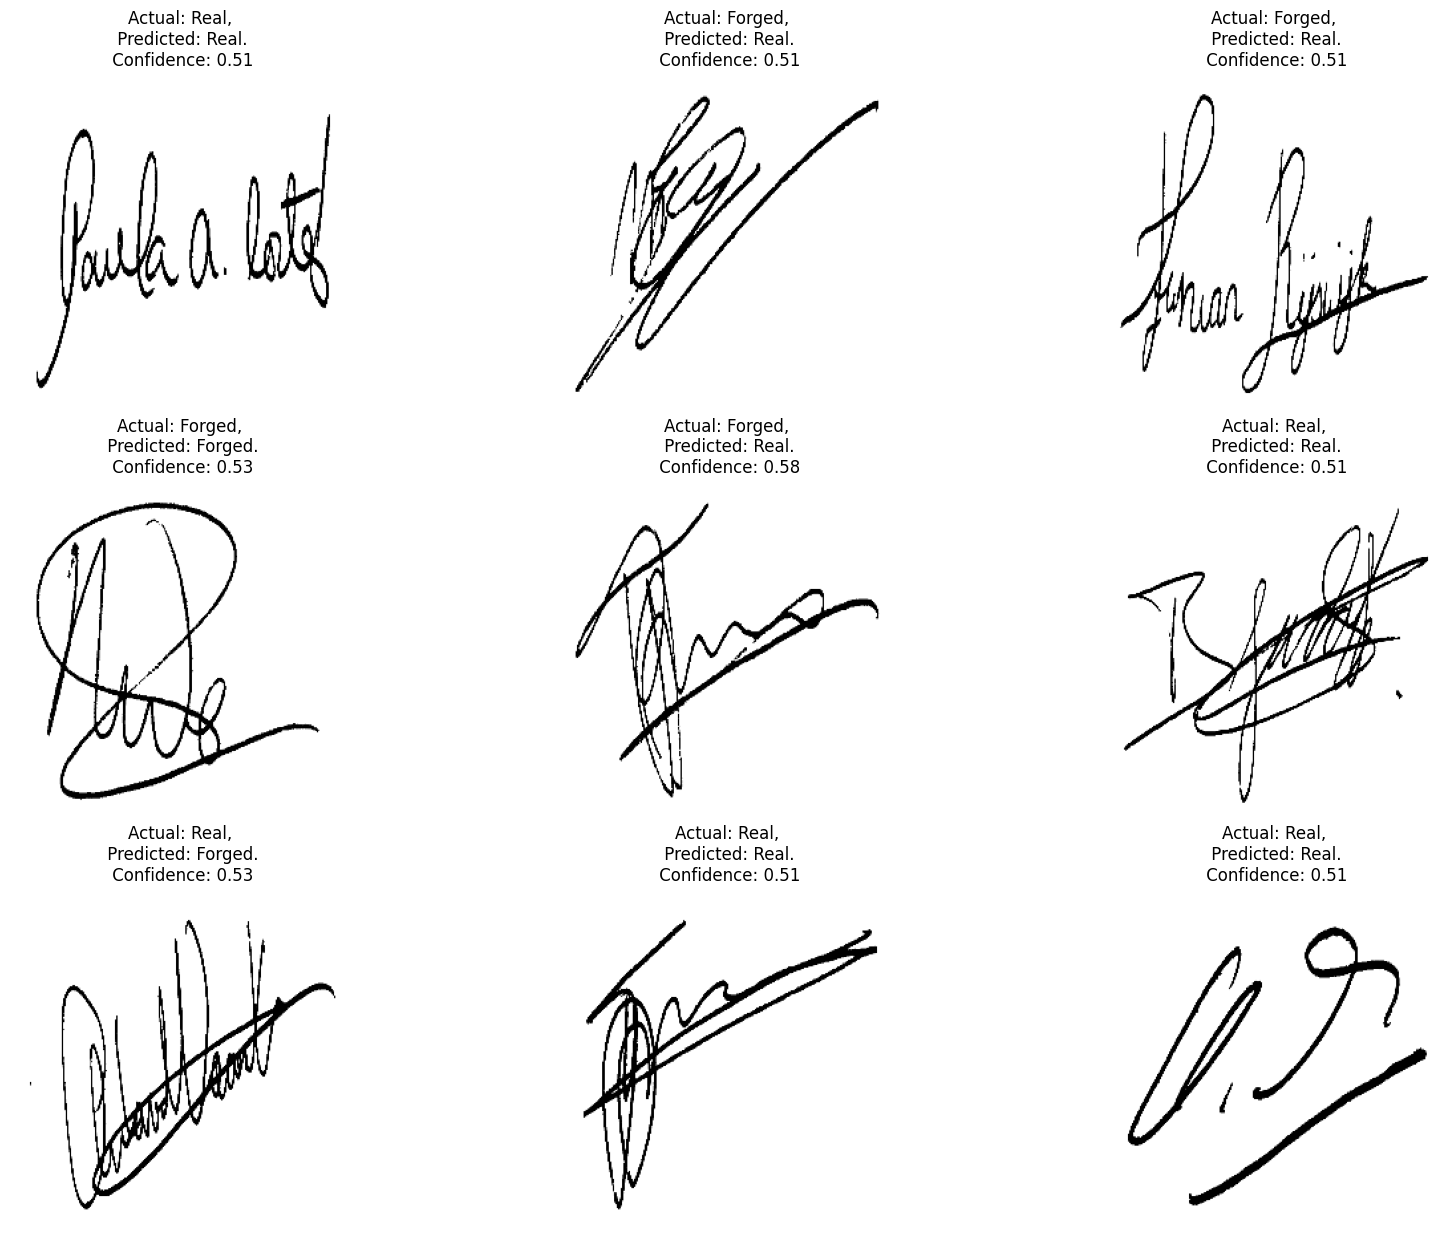

In [22]:
# Visualizing the predictions
plt.figure(figsize=(20, 15))

# Loop over the first 9 images and their labels
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = X_test[i].reshape(256, 256)  # Reshape the patches back to the original image shape
    plt.imshow(image, cmap='gray')  # Display the image
    
    # Predict the class and confidence
    predicted_class = np.argmax(model.predict(np.expand_dims(X_test[i], axis=0)))
    confidence = np.max(model.predict(np.expand_dims(X_test[i], axis=0)))  # Get the confidence score
    actual_class = np.argmax(y_test[i])  # Get the actual class from y_test
    class_names = ['Real', 'Forged']  # Class names
    
    plt.title(f'Actual: {class_names[actual_class]},\n Predicted: {class_names[predicted_class]}.\n Confidence: {confidence:.2f}')
    plt.axis('off')

plt.show()
